In [1]:
import sys, os

# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

In [2]:
general_path = r'C:\Users\weldl\Datasets\gtzan-dataset-music-genre-classification'
genres_list = os.listdir(f'{general_path}/genres_original/')
print(genres_list)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [3]:
all_songs = []
for genre in genres_list:
    for song_name in os.listdir(os.path.join(f'{general_path}/genres_original/', genre)):
        all_songs.append(os.path.join(f'{general_path}/genres_original/', genre, song_name))
print('all_songs:', len(all_songs))

all_songs: 1000


In [4]:
# Importing 1 file
y, sr = librosa.load(f'{general_path}/genres_original/reggae/reggae.00036.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')
# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [5]:
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

Audio File shape: (661794,)


In [6]:
# data_songs = []
# for gen in genres_list:
#     genres_files = os.listdir(os.path.join(f'{general_path}/genres_original/{gen}'))
#     for file in genres_files:
#         filename = os.path.join(f'{general_path}/genres_original/{gen}/{file}')
#         y, sr = librosa.load(filename)
#         data_songs.append(y)

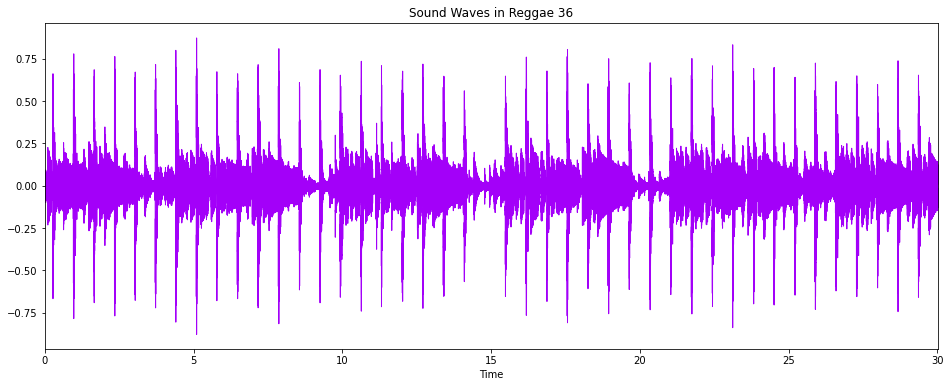

In [7]:
plt.figure(figsize = (16, 6))
librosa.display.waveplot(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in Reggae 36", fontsize = 12);

## Fourier Transform

In [8]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1293)


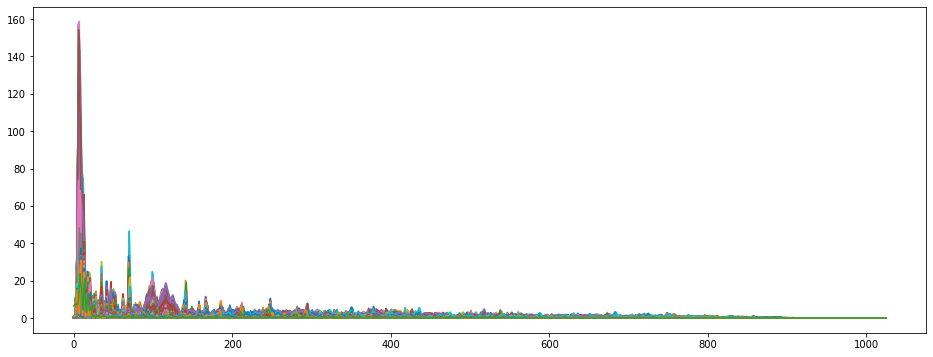

In [9]:
plt.figure(figsize = (16, 6))
plt.plot(D);

## The Spectrogram

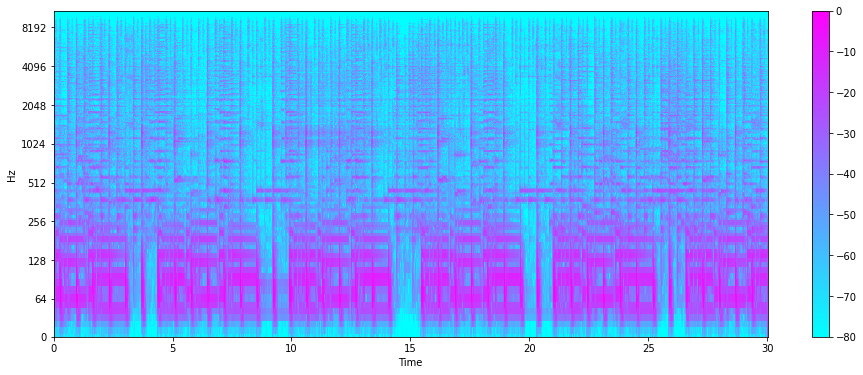

In [10]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.colorbar();

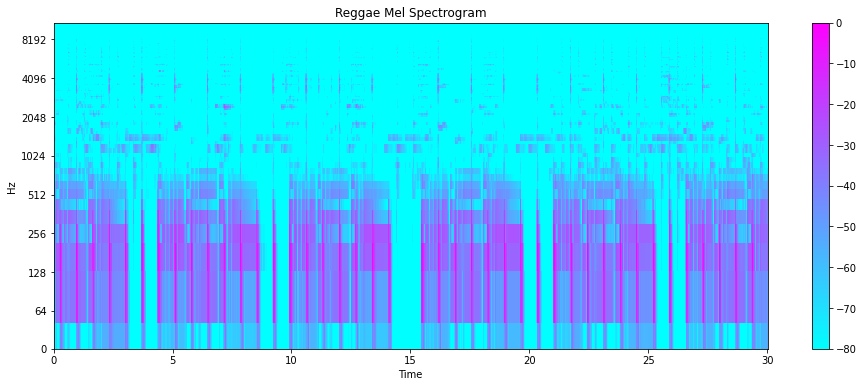

In [11]:
# Mel Spectrogram

y, sr = librosa.load(f'{general_path}/genres_original/reggae/reggae.00036.wav')
y, _ = librosa.effects.trim(y)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                         cmap = 'cool');
plt.colorbar();
plt.title("Reggae Mel Spectrogram", fontsize = 12);

In [12]:
ipd.Audio(f'{general_path}/genres_original/reggae/reggae.00036.wav')

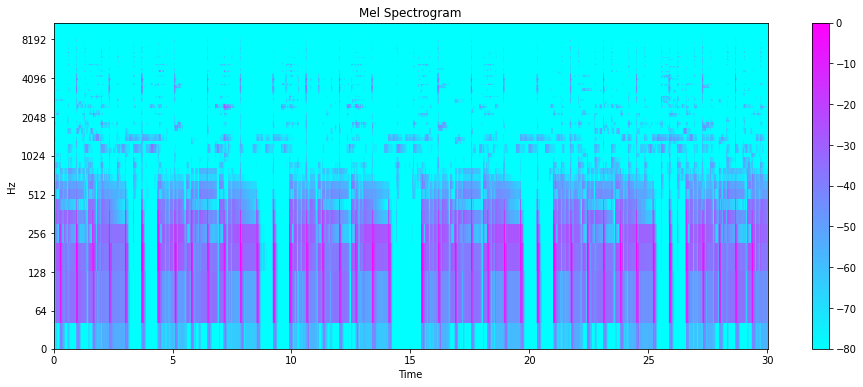

In [13]:
# Mel Spectrogram

y, sr = librosa.load(f'{general_path}/genres_original/reggae/reggae.00036.wav')
y, _ = librosa.effects.trim(y)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
plt.title("Mel Spectrogram", fontsize = 12);
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                         cmap = 'cool');
plt.colorbar();
plt.savefig('./gtzan_spectogram.png', dpi=100)
plt.show()

## Audio-files conversion to spectogram images

In [14]:
def get_spectogram_data(songs_array):
    spec_array = []
    for song_name in songs_array:
        y, sr = librosa.load(song_name)
        y, _ = librosa.effects.trim(y)
        S = librosa.feature.melspectrogram(y, sr=sr)
        S_DB = librosa.amplitude_to_db(S, ref=np.max)
        try:
            spec_array.append(S_DB[:, 0:1210].reshape((128, 1210, 1)))
        except ValueError:
            print(S_DB.shape)
    return np.array(spec_array)

spec_data = get_spectogram_data(all_songs)
spec_data.shape

(1000, 128, 1210, 1)

In [15]:
SPEC_SHAPE = spec_data.shape[1:]
SPEC_SHAPE

(128, 1210, 1)

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
import os
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf


In [17]:
def make_encoder_model(input_shape=(64,64, 3), output_len=100):
    encoder = Sequential()
    encoder.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=input_shape))
    encoder.add(LeakyReLU(alpha=0.2))
    encoder.add(Dropout(0.4))
    encoder.add(Conv2D(32, (3,3), strides=(2, 2), padding='same'))
    encoder.add(LeakyReLU(alpha=0.2))
    encoder.add(Dropout(0.4))
    encoder.add(Conv2D(16, (3,3), strides=(2, 2), padding='same'))
    encoder.add(LeakyReLU(alpha=0.2))
    encoder.add(Dropout(0.4))
    encoder.add(Flatten())
    encoder.add(Dense(output_len, activation='sigmoid'))
    return encoder

encoder = make_encoder_model(input_shape=SPEC_SHAPE, output_len=100)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 605, 64)       640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 605, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 605, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 303, 32)       18464     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 303, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 303, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 152, 16)       4